Isolation Forest Evaluation (Test Set):
Total samples: 292261
Anomalies detected: 82371
Percentage anomalies: 28.18%


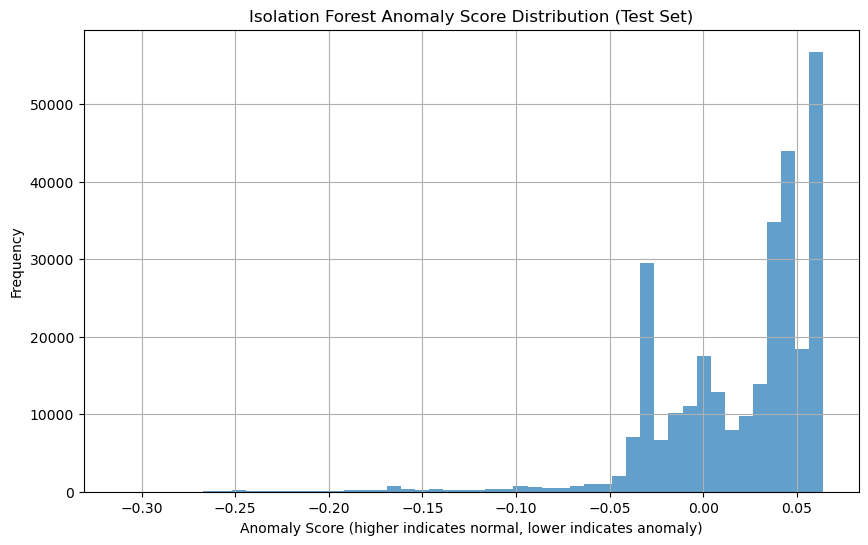

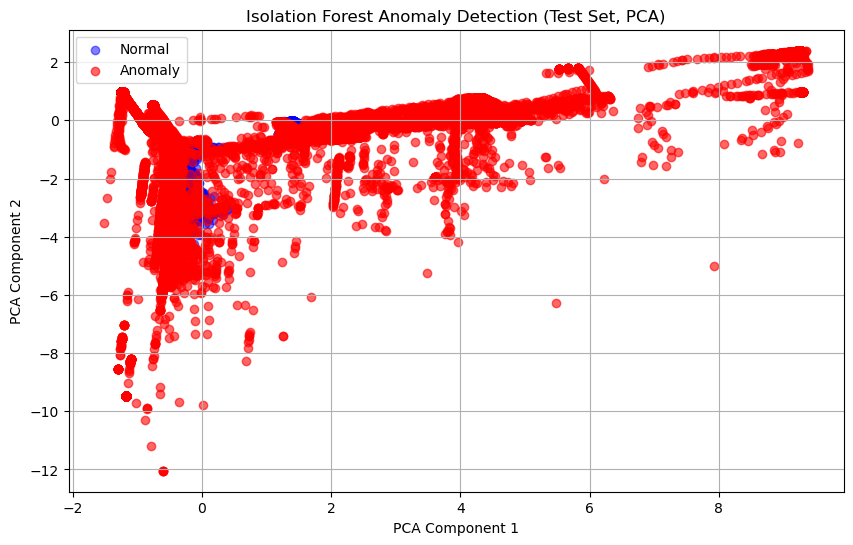

In [9]:
import pandas as pd
import numpy as np
from common_stage import prepareData
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Hyperparameters
hyperparams = {
    'n_estimators': 100,
    'contamination': 0.1,
    'max_samples': 1.0,
    'max_features': 0.6
}

# Features to be dropped
dropped_features = [
    'srv_count', 'srv_serror_rate', 'srv_rerror_rate',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate'
]

# Load and preprocess data
x_train, y_train, x_test, y_test = prepareData(scaling='standard', removed_features=dropped_features)

# Apply variance threshold
selector = VarianceThreshold(0.02)
x_train_selected = pd.DataFrame(selector.fit_transform(x_train), columns=x_train.columns[selector.get_support()])
x_test_selected = pd.DataFrame(selector.transform(x_test), columns=x_train_selected.columns)

# Isolation Forest model
iso_forest = IsolationForest(
    n_estimators=hyperparams['n_estimators'],
    contamination=hyperparams['contamination'],
    max_samples=hyperparams['max_samples'],
    max_features=hyperparams['max_features'],
    random_state=42,
    bootstrap=True,
    n_jobs=-1
)
iso_forest.fit(x_train_selected)

# Predictions (-1: anomaly, 1: normal)
test_preds = iso_forest.predict(x_test_selected)

# Anomaly Scoring
test_scores = iso_forest.decision_function(x_test_selected)
n_anomalies = np.sum(test_preds == -1)
percent_anomalies = (n_anomalies / len(test_preds)) * 100

print("Isolation Forest Evaluation (Test Set):")
print(f"Total samples: {len(test_preds)}")
print(f"Anomalies detected: {n_anomalies}")
print(f"Percentage anomalies: {percent_anomalies:.2f}%")

# Plot anomaly score distribution
plt.figure(figsize=(10, 6))
plt.hist(test_scores, bins=50, alpha=0.7)
plt.title("Isolation Forest Anomaly Score Distribution (Test Set)")
plt.xlabel("Anomaly Score (higher indicates normal, lower indicates anomaly)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# PCA Plot
pca = PCA(n_components=2)
x_test_pca = pca.fit_transform(x_test_selected)

plt.figure(figsize=(10, 6))
plt.scatter(x_test_pca[test_preds == 1, 0], x_test_pca[test_preds == 1, 1], 
            c='blue', alpha=0.5, label='Normal')
plt.scatter(x_test_pca[test_preds == -1, 0], x_test_pca[test_preds == -1, 1], 
            c='red', alpha=0.6, label='Anomaly')
plt.title("Isolation Forest Anomaly Detection (Test Set, PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()